In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

In [3]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

print("Shape of train: ", train.shape)
print("Shape of test: ", test.shape)

Shape of train:  (1460, 81)
Shape of test:  (1459, 80)


In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
df = pd.concat((train, test))
temp_df = df
print("Shape of df: ", df.shape)

Shape of df:  (2919, 81)


In [7]:
df.head(6)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallCond  

In [9]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,...,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,...,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [10]:
df.select_dtypes(include=['int64', 'float64']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [11]:
df.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [12]:
df = df.set_index("Id")

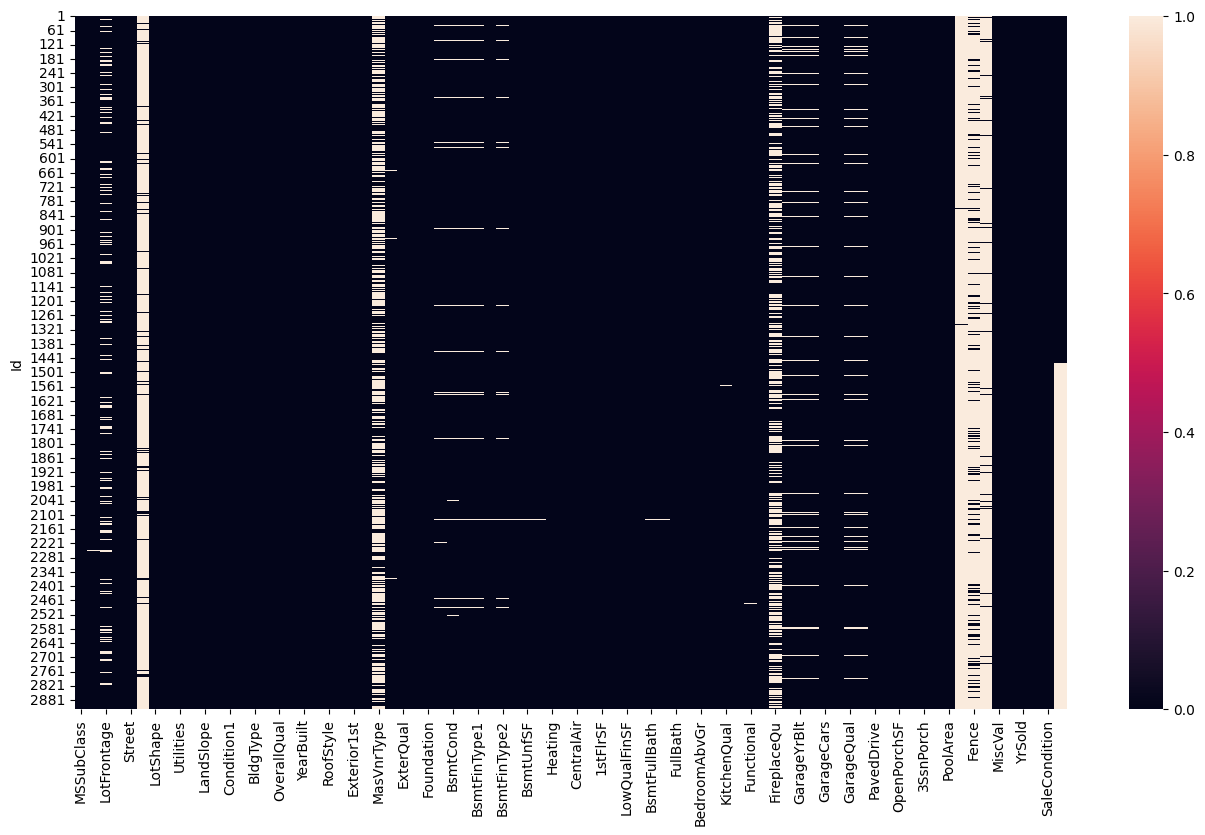

In [13]:
plt.figure(figsize=(16,9))
sns.heatmap(df.isnull())
plt.show()

In [14]:
null_percent = df.isnull().sum()/df.shape[0]*100
null_percent

MSSubClass        0.000000
MSZoning          0.137033
LotFrontage      16.649538
LotArea           0.000000
Street            0.000000
                   ...    
MoSold            0.000000
YrSold            0.000000
SaleType          0.034258
SaleCondition     0.000000
SalePrice        49.982871
Length: 80, dtype: float64

In [15]:
col_for_drop = null_percent[null_percent > 20].keys() # if the null value % 20 or > 20 so need to drop it

In [16]:
df.drop(col_for_drop, axis='columns', inplace=True)
print(df.shape)

(2919, 73)


In [17]:
for i in df.columns:
    print(i + "\t" + str(len(df[i].unique())))

MSSubClass	16
MSZoning	6
LotFrontage	129
LotArea	1951
Street	2
LotShape	4
LandContour	4
Utilities	3
LotConfig	5
LandSlope	3
Neighborhood	25
Condition1	9
Condition2	8
BldgType	5
HouseStyle	8
OverallQual	10
OverallCond	9
YearBuilt	118
YearRemodAdd	61
RoofStyle	6
RoofMatl	8
Exterior1st	16
Exterior2nd	17
MasVnrArea	445
ExterQual	4
ExterCond	5
Foundation	6
BsmtQual	5
BsmtCond	5
BsmtExposure	5
BsmtFinType1	7
BsmtFinSF1	992
BsmtFinType2	7
BsmtFinSF2	273
BsmtUnfSF	1136
TotalBsmtSF	1059
Heating	6
HeatingQC	5
CentralAir	2
Electrical	6
1stFlrSF	1083
2ndFlrSF	635
LowQualFinSF	36
GrLivArea	1292
BsmtFullBath	5
BsmtHalfBath	4
FullBath	5
HalfBath	3
BedroomAbvGr	8
KitchenAbvGr	4
KitchenQual	5
TotRmsAbvGrd	14
Functional	8
Fireplaces	5
GarageType	7
GarageYrBlt	104
GarageFinish	4
GarageCars	7
GarageArea	604
GarageQual	6
GarageCond	6
PavedDrive	3
WoodDeckSF	379
OpenPorchSF	252
EnclosedPorch	183
3SsnPorch	31
ScreenPorch	121
PoolArea	14
MiscVal	38
MoSold	12
YrSold	5
SaleType	10
SaleCondition	6


In [18]:
for i in df.columns:
    print("Unique value of:>>> {} ({})\n{}\n".format(i, len(df[i].unique()), df[i].unique()))

Unique value of:>>> MSSubClass (16)
[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40 150]

Unique value of:>>> MSZoning (6)
['RL' 'RM' 'C (all)' 'FV' 'RH' nan]

Unique value of:>>> LotFrontage (129)
[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.  26.
  25. 119.  31.  28. 117. 113. 125. 135. 136.  22. 123. 195. 155. 126.
 200. 131. 133.]

Unique value of:>>> LotArea (1951)
[ 8450  9600 11250 ...  1894 20000 10441]

Unique value of:>>> Street (2)
['Pave' 'Grvl']

Unique

In [19]:
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/tmp/ipykernel_18/4003130952.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  bar = sns.distplot(train["SalePrice"])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


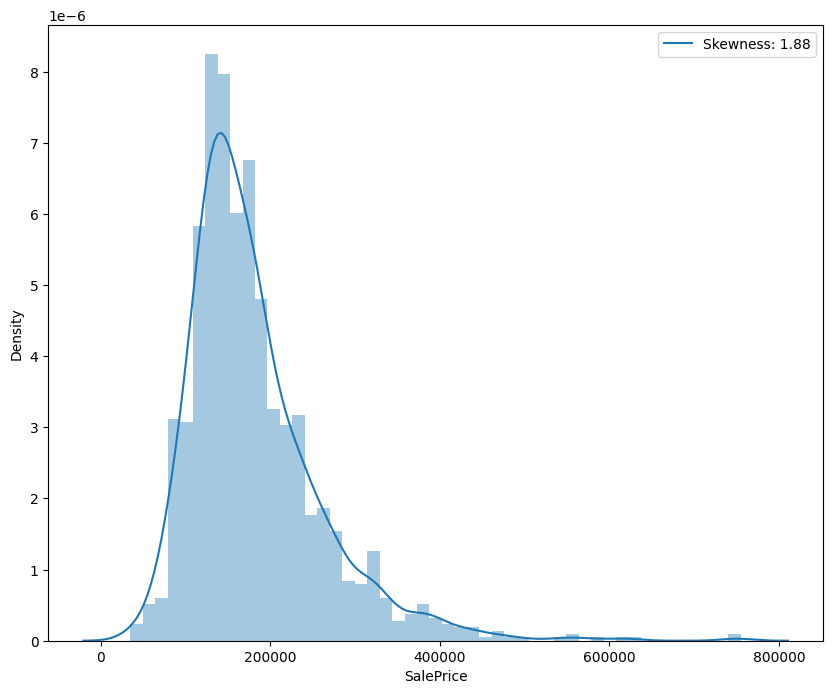

In [20]:
plt.figure(figsize=(10,8))
bar = sns.distplot(train["SalePrice"])
bar.legend(["Skewness: {:.2f}".format(train['SalePrice'].skew())])
plt.show()

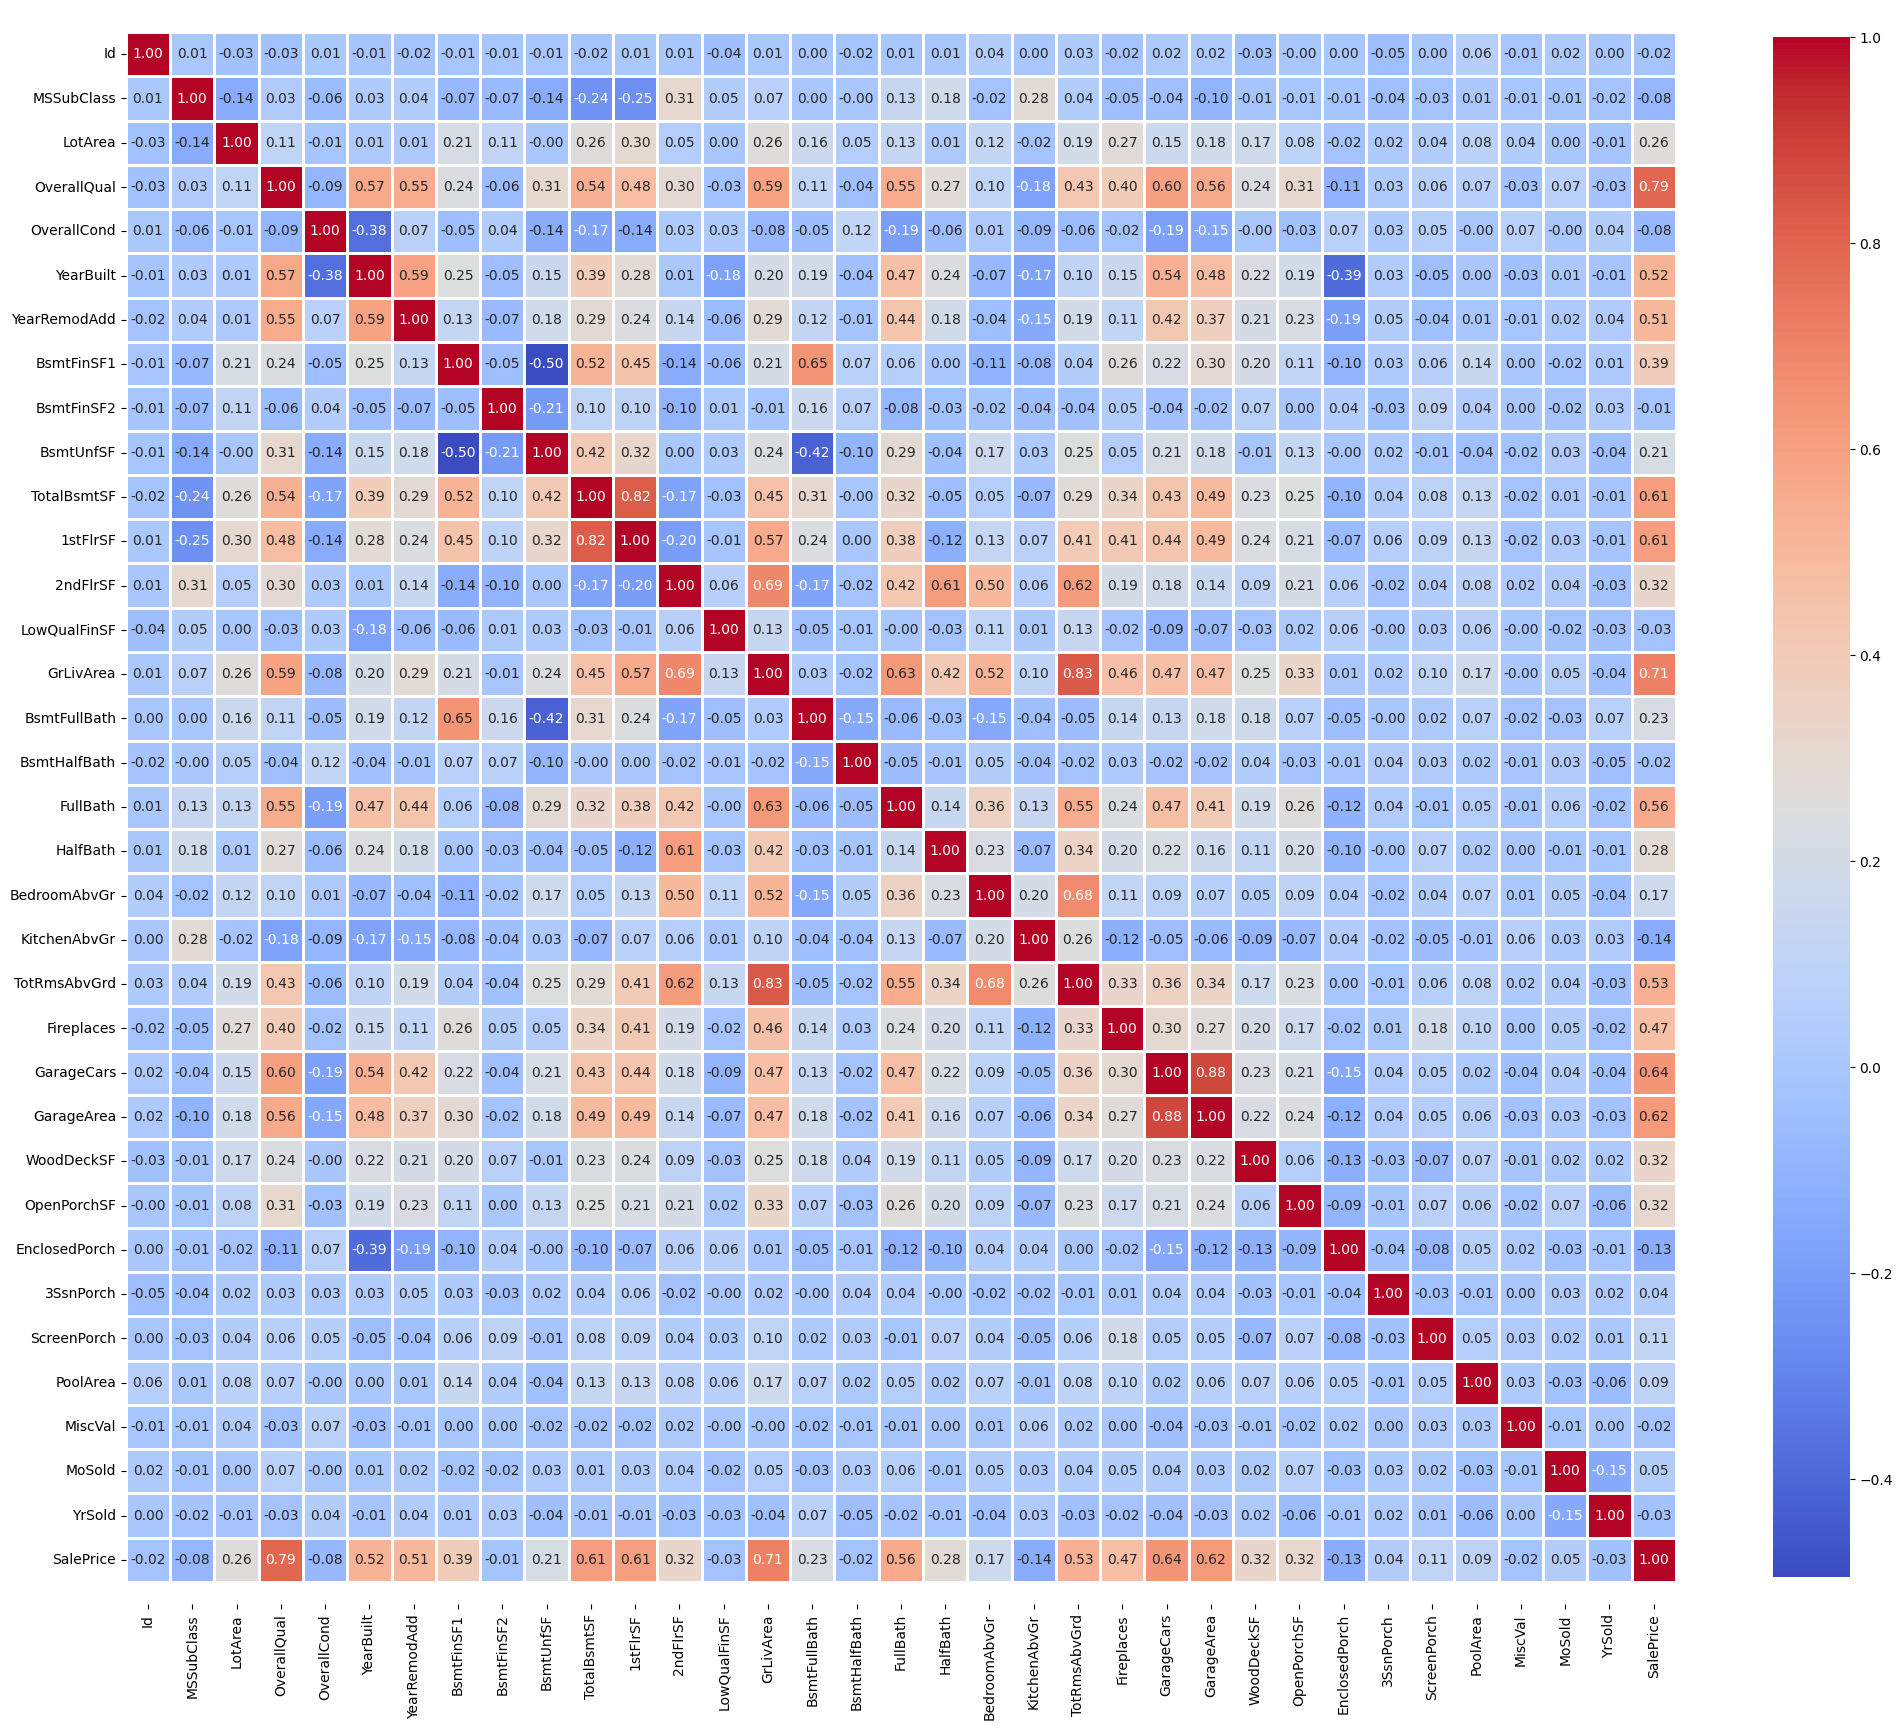

In [21]:
train_numeric = train.apply(pd.to_numeric, errors='coerce')
train_numeric.dropna(axis=1, inplace=True)
plt.figure(figsize=(25, 25))
ax = sns.heatmap(train_numeric.corr(), cmap="coolwarm", annot=True, linewidth=2, annot_kws={"size": 10}, fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [22]:
train_numeric = train.select_dtypes(include=['number'])
hig_corr = train_numeric.corr()
hig_corr_features = hig_corr.index[abs(hig_corr["SalePrice"]) >= 0.5]
hig_corr_features

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'SalePrice'],
      dtype='object')

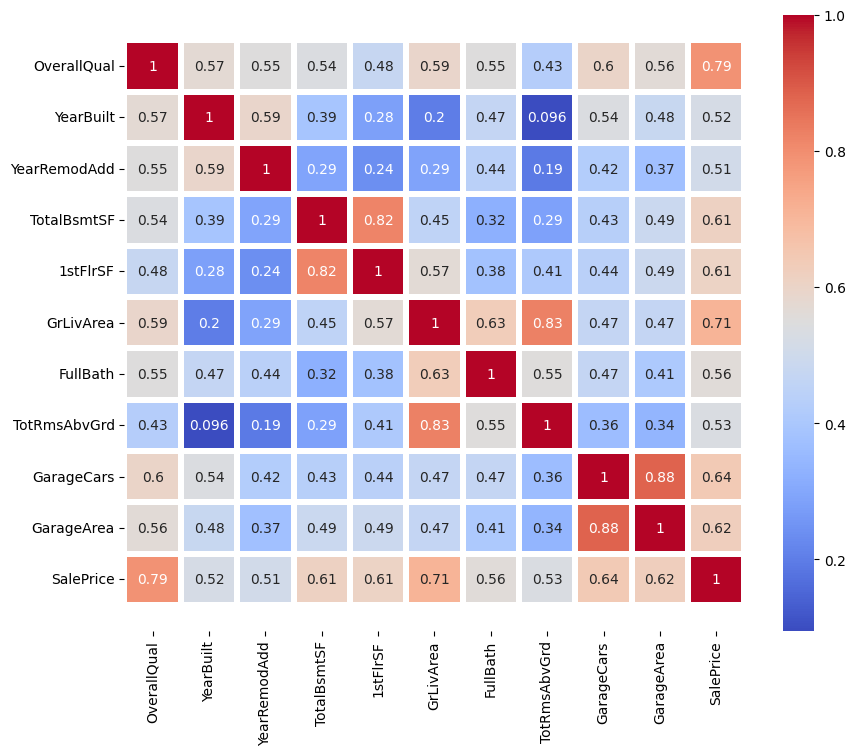

In [23]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(train[hig_corr_features].corr(), cmap = "coolwarm", annot=True, linewidth=3)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

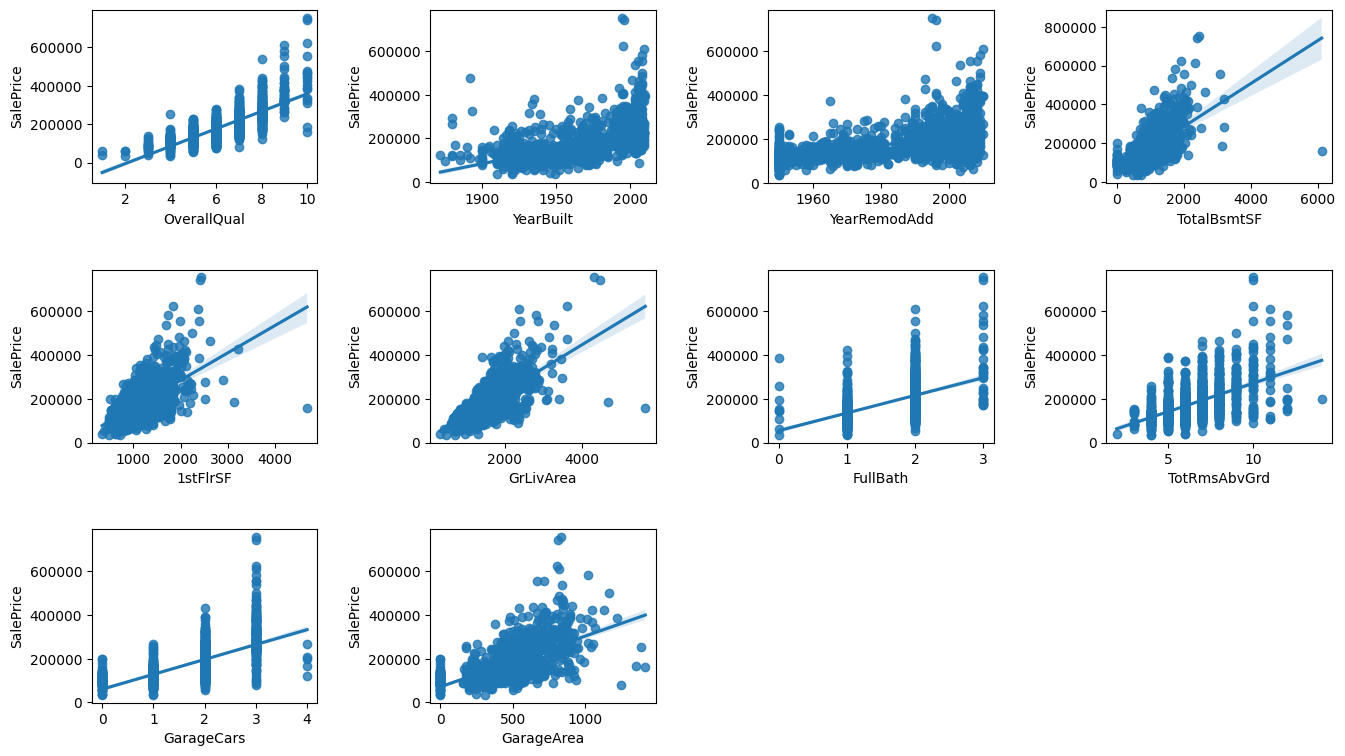

In [24]:
plt.figure(figsize=(16,9))
for i in range(len(hig_corr_features)):
    if i <= 9:
        plt.subplot(3,4,i+1)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
        sns.regplot(data=train, x = hig_corr_features[i], y = 'SalePrice')

In [25]:
missing_col = df.columns[df.isnull().any()]
missing_col

Index(['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual',
       'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'SaleType'],
      dtype='object')

In [26]:
bsmt_col = ['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'TotalBsmtSF']
bsmt_feat = df[bsmt_col]
bsmt_feat

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
Id,,,,,,,,,,,
1,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,856.0
2,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,1262.0
3,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,920.0
4,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,756.0
5,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,1145.0
...,...,...,...,...,...,...,...,...,...,...,...
2915,TA,No,0.0,0.0,Unf,Unf,0.0,0.0,TA,546.0,546.0
2916,TA,No,252.0,0.0,Rec,Unf,0.0,0.0,TA,294.0,546.0
2917,TA,No,1224.0,0.0,ALQ,Unf,1.0,0.0,TA,0.0,1224.0


In [27]:
bsmt_feat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 1 to 2919
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BsmtCond      2837 non-null   object 
 1   BsmtExposure  2837 non-null   object 
 2   BsmtFinSF1    2918 non-null   float64
 3   BsmtFinSF2    2918 non-null   float64
 4   BsmtFinType1  2840 non-null   object 
 5   BsmtFinType2  2839 non-null   object 
 6   BsmtFullBath  2917 non-null   float64
 7   BsmtHalfBath  2917 non-null   float64
 8   BsmtQual      2838 non-null   object 
 9   BsmtUnfSF     2918 non-null   float64
 10  TotalBsmtSF   2918 non-null   float64
dtypes: float64(6), object(5)
memory usage: 273.7+ KB


In [28]:
bsmt_feat.isnull().sum()

BsmtCond        82
BsmtExposure    82
BsmtFinSF1       1
BsmtFinSF2       1
BsmtFinType1    79
BsmtFinType2    80
BsmtFullBath     2
BsmtHalfBath     2
BsmtQual        81
BsmtUnfSF        1
TotalBsmtSF      1
dtype: int64

In [29]:
bsmt_feat = bsmt_feat[bsmt_feat.isnull().any(axis=1)]
bsmt_feat

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
Id,,,,,,,,,,,
18,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
40,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
91,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
103,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
157,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2804,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
2805,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
2825,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0


In [30]:
bsmt_feat_all_nan = bsmt_feat[(bsmt_feat.isnull() | bsmt_feat.isin([0])).all(1)]
bsmt_feat_all_nan

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
Id,,,,,,,,,,,
18,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
40,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
91,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
103,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
157,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2804,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
2805,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
2825,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0


In [31]:
bsmt_feat_all_nan.shape

(79, 11)

In [32]:
qual = list(df.loc[:, df.dtypes == 'object'].columns.values)
qual

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [33]:
# Fillinf the mising value in bsmt features
for i in bsmt_col:
    if i in qual:
        bsmt_feat_all_nan[i] = bsmt_feat_all_nan[i].replace(np.nan, 'NA') # replace the NAN value by 'NA'
    else:
        bsmt_feat_all_nan[i] = bsmt_feat_all_nan[i].replace(np.nan, 0) # replace the NAN value inplace of 0

bsmt_feat.update(bsmt_feat_all_nan) # update bsmt_feat df by bsmt_feat_all_nan
df.update(bsmt_feat_all_nan) # update df by bsmt_feat_all_nan

"""
>>> df = pd.DataFrame({'A': [1, 2, 3],
...                    'B': [400, 500, 600]})
>>> new_df = pd.DataFrame({'B': [4, 5, 6],
...                        'C': [7, 8, 9]})
>>> df.update(new_df)
>>> df
   A  B
0  1  4
1  2  5
2  3  6
"""

/tmp/ipykernel_18/2004241291.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsmt_feat_all_nan[i] = bsmt_feat_all_nan[i].replace(np.nan, 'NA') # replace the NAN value by 'NA'
/tmp/ipykernel_18/2004241291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsmt_feat_all_nan[i] = bsmt_feat_all_nan[i].replace(np.nan, 0) # replace the NAN value inplace of 0


"\n>>> df = pd.DataFrame({'A': [1, 2, 3],\n...                    'B': [400, 500, 600]})\n>>> new_df = pd.DataFrame({'B': [4, 5, 6],\n...                        'C': [7, 8, 9]})\n>>> df.update(new_df)\n>>> df\n   A  B\n0  1  4\n1  2  5\n2  3  6\n"

In [34]:
bsmt_feat = bsmt_feat[bsmt_feat.isin([np.nan]).any(axis=1)]
bsmt_feat

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
Id,,,,,,,,,,,
333,TA,No,1124.0,479.0,GLQ,NaN,1.0,0.0,Gd,1603.0,3206.0
949,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,936.0,936.0
1488,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,1595.0,1595.0
2041,NaN,Mn,1044.0,382.0,GLQ,Rec,1.0,0.0,Gd,0.0,1426.0
2186,NaN,No,1033.0,0.0,BLQ,Unf,0.0,1.0,TA,94.0,1127.0
2218,Fa,No,0.0,0.0,Unf,Unf,0.0,0.0,NaN,173.0,173.0
2219,TA,No,0.0,0.0,Unf,Unf,0.0,0.0,NaN,356.0,356.0
2349,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,725.0,725.0
2525,NaN,Av,755.0,0.0,ALQ,Unf,0.0,0.0,TA,240.0,995.0


In [35]:
bsmt_feat.shape

(9, 11)

In [36]:
print(df['BsmtFinSF2'].max())
print(df['BsmtFinSF2'].min())

1526.0
0.0


In [37]:
pd.cut(range(0,1526),5)

[(-1.525, 305.0], (-1.525, 305.0], (-1.525, 305.0], (-1.525, 305.0], (-1.525, 305.0], ..., (1220.0, 1525.0], (1220.0, 1525.0], (1220.0, 1525.0], (1220.0, 1525.0], (1220.0, 1525.0]]
Length: 1526
Categories (5, interval[float64, right]): [(-1.525, 305.0] < (305.0, 610.0] < (610.0, 915.0] < (915.0, 1220.0] < (1220.0, 1525.0]]

In [38]:
df_slice = df[(df['BsmtFinSF2'] >= 305) & (df['BsmtFinSF2'] <= 610)]
df_slice

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
27,20,RL,60.0,7200,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,32,0,0,0,0,0,5,2010,WD,Normal
44,20,RL,NaN,9200,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,0,7,2008,WD,Normal
45,20,RL,70.0,7945,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,5,2006,WD,Normal
74,20,RL,85.0,10200,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,5,2010,WD,Normal
174,20,RL,80.0,10197,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,20,0,0,0,0,0,6,2008,COD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,80,RL,80.0,9600,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,78,0,0,0,0,0,7,2006,WD,Normal
2807,20,RL,50.0,5500,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,120,0,0,0,0,0,5,2006,WD,Normal
2844,80,RL,42.0,10385,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,0,4,2006,WD,Normal


In [39]:
bsmt_feat.at[333,'BsmtFinType2'] = df_slice['BsmtFinType2'].mode()[0]

In [40]:
bsmt_feat

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
Id,,,,,,,,,,,
333,TA,No,1124.0,479.0,GLQ,Rec,1.0,0.0,Gd,1603.0,3206.0
949,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,936.0,936.0
1488,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,1595.0,1595.0
2041,NaN,Mn,1044.0,382.0,GLQ,Rec,1.0,0.0,Gd,0.0,1426.0
2186,NaN,No,1033.0,0.0,BLQ,Unf,0.0,1.0,TA,94.0,1127.0
2218,Fa,No,0.0,0.0,Unf,Unf,0.0,0.0,NaN,173.0,173.0
2219,TA,No,0.0,0.0,Unf,Unf,0.0,0.0,NaN,356.0,356.0
2349,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,725.0,725.0
2525,NaN,Av,755.0,0.0,ALQ,Unf,0.0,0.0,TA,240.0,995.0


In [41]:
bsmt_feat['BsmtExposure'] = bsmt_feat['BsmtExposure'].replace(np.nan, df[df['BsmtQual'] =='Gd']['BsmtExposure'].mode()[0])

/tmp/ipykernel_18/4112458698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsmt_feat['BsmtExposure'] = bsmt_feat['BsmtExposure'].replace(np.nan, df[df['BsmtQual'] =='Gd']['BsmtExposure'].mode()[0])


In [42]:
bsmt_feat['BsmtCond'] = bsmt_feat['BsmtCond'].replace(np.nan, df['BsmtCond'].mode()[0])
bsmt_feat['BsmtQual'] = bsmt_feat['BsmtQual'].replace(np.nan, df['BsmtQual'].mode()[0])

/tmp/ipykernel_18/1418674735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsmt_feat['BsmtCond'] = bsmt_feat['BsmtCond'].replace(np.nan, df['BsmtCond'].mode()[0])
/tmp/ipykernel_18/1418674735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsmt_feat['BsmtQual'] = bsmt_feat['BsmtQual'].replace(np.nan, df['BsmtQual'].mode()[0])


In [43]:
df.update(bsmt_feat)

In [44]:
bsmt_feat.isnull().sum()

BsmtCond        0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtFinType1    0
BsmtFinType2    0
BsmtFullBath    0
BsmtHalfBath    0
BsmtQual        0
BsmtUnfSF       0
TotalBsmtSF     0
dtype: int64

In [45]:
df.columns[df.isnull().any()]

Index(['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrArea', 'Electrical', 'KitchenQual', 'Functional', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'SaleType'],
      dtype='object')

In [46]:
garage_col = ['GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',]
garage_feat = df[garage_col]
garage_feat = garage_feat[garage_feat.isnull().any(axis=1)]
garage_feat

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
Id,,,,,,,
40,0.0,0.0,NaN,NaN,NaN,NaN,NaN
49,0.0,0.0,NaN,NaN,NaN,NaN,NaN
79,0.0,0.0,NaN,NaN,NaN,NaN,NaN
89,0.0,0.0,NaN,NaN,NaN,NaN,NaN
90,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2894,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2910,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2914,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [47]:
garage_feat.shape

(159, 7)

In [48]:
garage_feat_all_nan = garage_feat[(garage_feat.isnull() | garage_feat.isin([0])).all(1)]
garage_feat_all_nan.shape

(157, 7)

In [49]:
for i in garage_feat:
    if i in qual:
        garage_feat_all_nan[i] = garage_feat_all_nan[i].replace(np.nan, 'NA')
    else:
        garage_feat_all_nan[i] = garage_feat_all_nan[i].replace(np.nan, 0)
        
garage_feat.update(garage_feat_all_nan)
df.update(garage_feat_all_nan)

/tmp/ipykernel_18/1495594874.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  garage_feat_all_nan[i] = garage_feat_all_nan[i].replace(np.nan, 0)
/tmp/ipykernel_18/1495594874.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  garage_feat_all_nan[i] = garage_feat_all_nan[i].replace(np.nan, 'NA')


In [50]:
garage_feat = garage_feat[garage_feat.isnull().any(axis=1)]
garage_feat

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
Id,,,,,,,
2127,360.0,1.0,NaN,NaN,NaN,Detchd,NaN
2577,NaN,NaN,NaN,NaN,NaN,Detchd,NaN


In [51]:
for i in garage_col:
    garage_feat[i] = garage_feat[i].replace(np.nan, df[df['GarageType'] == 'Detchd'][i].mode()[0])

/tmp/ipykernel_18/727674534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  garage_feat[i] = garage_feat[i].replace(np.nan, df[df['GarageType'] == 'Detchd'][i].mode()[0])


In [52]:
garage_feat.isnull().any()

GarageArea      False
GarageCars      False
GarageCond      False
GarageFinish    False
GarageQual      False
GarageType      False
GarageYrBlt     False
dtype: bool

In [53]:
df.update(garage_feat)

In [54]:
df.columns[df.isnull().any()]

Index(['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrArea', 'Electrical', 'KitchenQual', 'Functional', 'SaleType'],
      dtype='object')

In [55]:
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])
# Remove the line that tries to access the 'MasVnrType' column
# df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])


In [56]:
df.columns[df.isnull().any()]

Index(['LotFrontage', 'MasVnrArea'], dtype='object')

In [57]:
df[df['MasVnrArea'].isnull() == True]['MasVnrArea'].unique()

array([nan])

In [58]:
if 'MasVnrType' in df.columns and 'MasVnrArea' in df.columns:
    df.loc[(df['MasVnrType'] == 'None') & (df['MasVnrArea'].isnull()), 'MasVnrArea'] = 0
else:
    print("Columns 'MasVnrType' or 'MasVnrArea' not found in the DataFrame.")

Columns 'MasVnrType' or 'MasVnrArea' not found in the DataFrame.


In [59]:
df.isnull().sum()/df.shape[0] * 100

MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      16.649538
LotArea           0.000000
Street            0.000000
                   ...    
MiscVal           0.000000
MoSold            0.000000
YrSold            0.000000
SaleType          0.000000
SaleCondition     0.000000
Length: 73, dtype: float64

In [60]:
lotconfig = ['Corner', 'Inside', 'CulDSac', 'FR2', 'FR3']
for i in lotconfig:
    mean_lot_frontage = df[df['LotConfig'] == i]['LotFrontage'].mean()
    df['LotFrontage'] = df['LotFrontage'].fillna(mean_lot_frontage)

In [61]:
df.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 73, dtype: int64

In [62]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPor

In [63]:
feat_dtype_convert = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
for i in feat_dtype_convert:
    df[i] = df[i].astype(str)

In [64]:
df['MoSold'].unique()

array([ 2,  5,  9, 12, 10,  8, 11,  4,  1,  7,  3,  6])

In [65]:
import calendar
df['MoSold'] = df['MoSold'].apply(lambda x : calendar.month_abbr[x])

In [66]:
df['MoSold'].unique()

array(['Feb', 'May', 'Sep', 'Dec', 'Oct', 'Aug', 'Nov', 'Apr', 'Jan',
       'Jul', 'Mar', 'Jun'], dtype=object)

In [67]:
quan = list(df.loc[:, df.dtypes != 'object'].columns.values)

In [68]:
quan

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [69]:
len(quan)

30

In [70]:
obj_feat = list(df.loc[:, df.dtypes == 'object'].columns.values)
obj_feat

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [71]:
from pandas.api.types import CategoricalDtype
df['BsmtCond'] = df['BsmtCond'].astype(CategoricalDtype(categories=['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)).cat.codes

In [72]:
df['BsmtCond'].unique()

array([3, 4, 0, 2, 1], dtype=int8)

In [73]:
df['BsmtExposure'] = df['BsmtExposure'].astype(CategoricalDtype(categories=['NA', 'Mn', 'Av', 'Gd'], ordered = True)).cat.codes

In [74]:
df['BsmtExposure'].unique()

array([-1,  3,  1,  2,  0], dtype=int8)

In [75]:
df['BsmtFinType1'] = df['BsmtFinType1'].astype(CategoricalDtype(categories=['NA', 'Unf', 'LwQ', 'Rec', 'BLQ','ALQ', 'GLQ'], ordered = True)).cat.codes
df['BsmtFinType2'] = df['BsmtFinType2'].astype(CategoricalDtype(categories=['NA', 'Unf', 'LwQ', 'Rec', 'BLQ','ALQ', 'GLQ'], ordered = True)).cat.codes
df['BsmtQual'] = df['BsmtQual'].astype(CategoricalDtype(categories=['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)).cat.codes
df['ExterQual'] = df['ExterQual'].astype(CategoricalDtype(categories=['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)).cat.codes
df['ExterCond'] = df['ExterCond'].astype(CategoricalDtype(categories=['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)).cat.codes
df['Functional'] = df['Functional'].astype(CategoricalDtype(categories=['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod','Min2','Min1', 'Typ'], ordered = True)).cat.codes
df['GarageCond'] = df['GarageCond'].astype(CategoricalDtype(categories=['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)).cat.codes
df['GarageQual'] = df['GarageQual'].astype(CategoricalDtype(categories=['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)).cat.codes
df['GarageFinish'] = df['GarageFinish'].astype(CategoricalDtype(categories=['NA', 'Unf', 'RFn', 'Fin'], ordered = True)).cat.codes
df['HeatingQC'] = df['HeatingQC'].astype(CategoricalDtype(categories=['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)).cat.codes
df['KitchenQual'] = df['KitchenQual'].astype(CategoricalDtype(categories=['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)).cat.codes
df['PavedDrive'] = df['PavedDrive'].astype(CategoricalDtype(categories=['N', 'P', 'Y'], ordered = True)).cat.codes
df['Utilities'] = df['Utilities'].astype(CategoricalDtype(categories=['ELO', 'NASeWa', 'NASeWr', 'AllPub'], ordered = True)).cat.codes

In [76]:
df['Utilities'].unique()

array([ 3, -1], dtype=int8)

In [77]:
skewed_features = ['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF']


In [78]:
quan == skewed_features

False

/tmp/ipykernel_18/3849293803.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df[skewed_features[i]])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/3849293803.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histogra

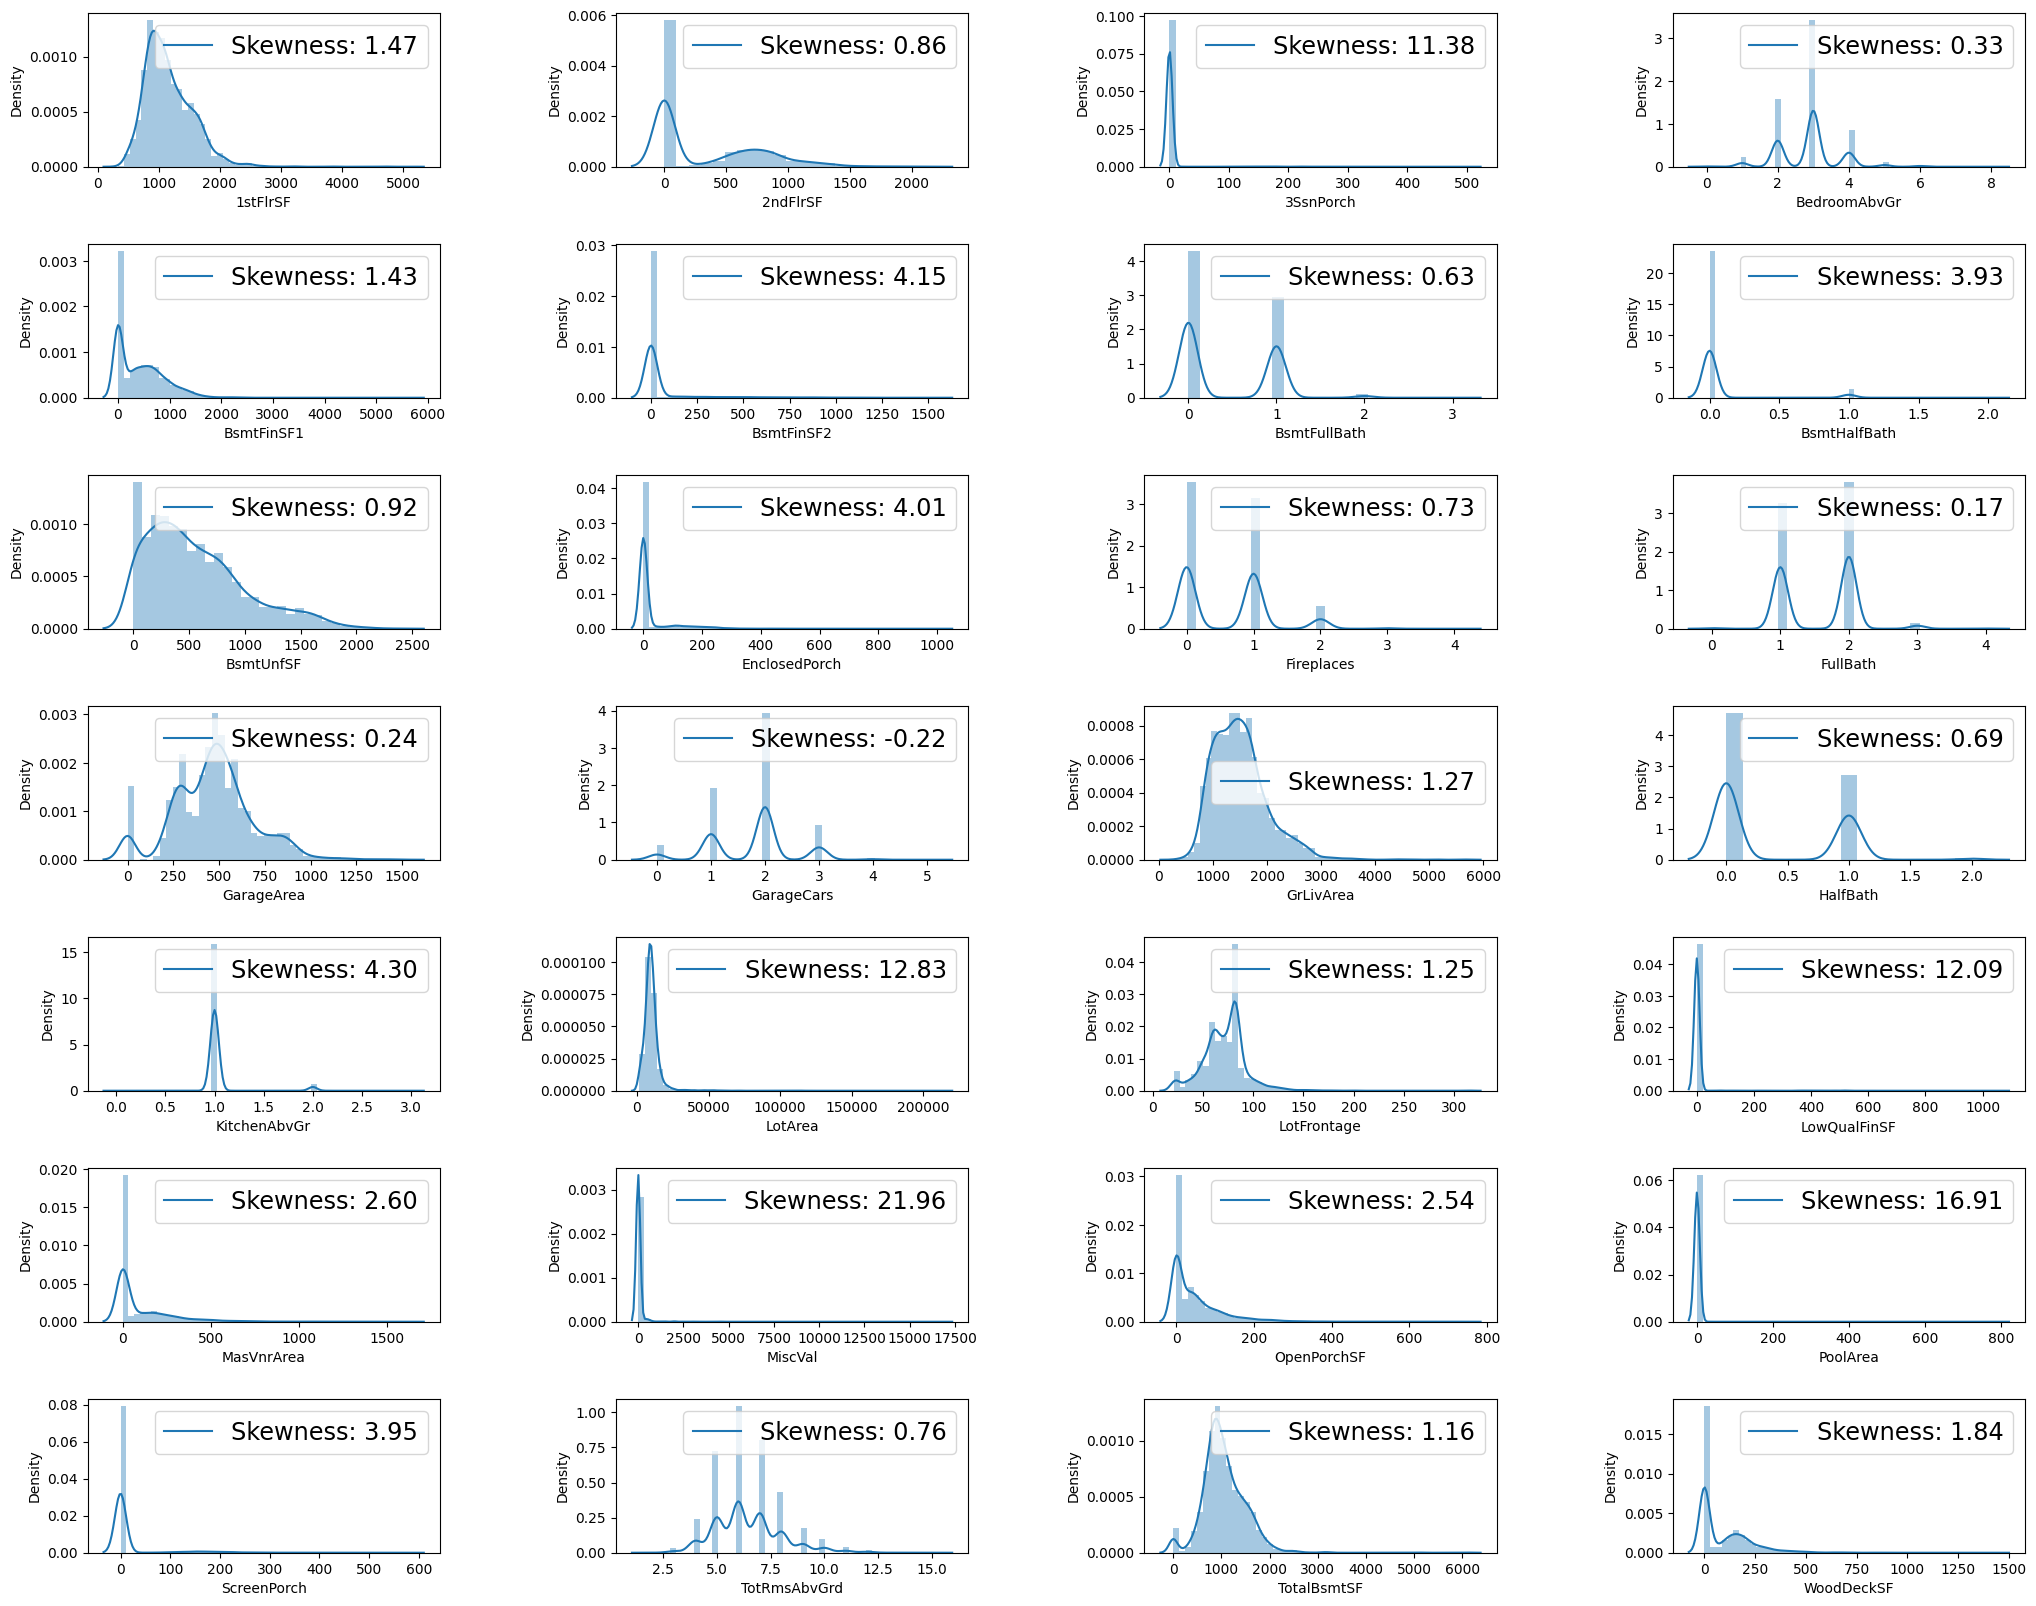

In [79]:
plt.figure(figsize=(25,20))
for i in range(len(skewed_features)):
    if i <= 28:
        plt.subplot(7,4,i+1)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
        ax = sns.distplot(df[skewed_features[i]])
        ax.legend(["Skewness: {:.2f}".format(df[skewed_features[i]].skew())], fontsize = 'xx-large')

In [80]:
df_back = df

In [81]:
for i in skewed_features:
    df[i] = np.log(df[i] + 1)# decrease the skewnwnes of the data
for i in skewed_features:
    df[i] = np.log(df[i] + 1)

/tmp/ipykernel_18/3849293803.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df[skewed_features[i]])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/3849293803.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histogra

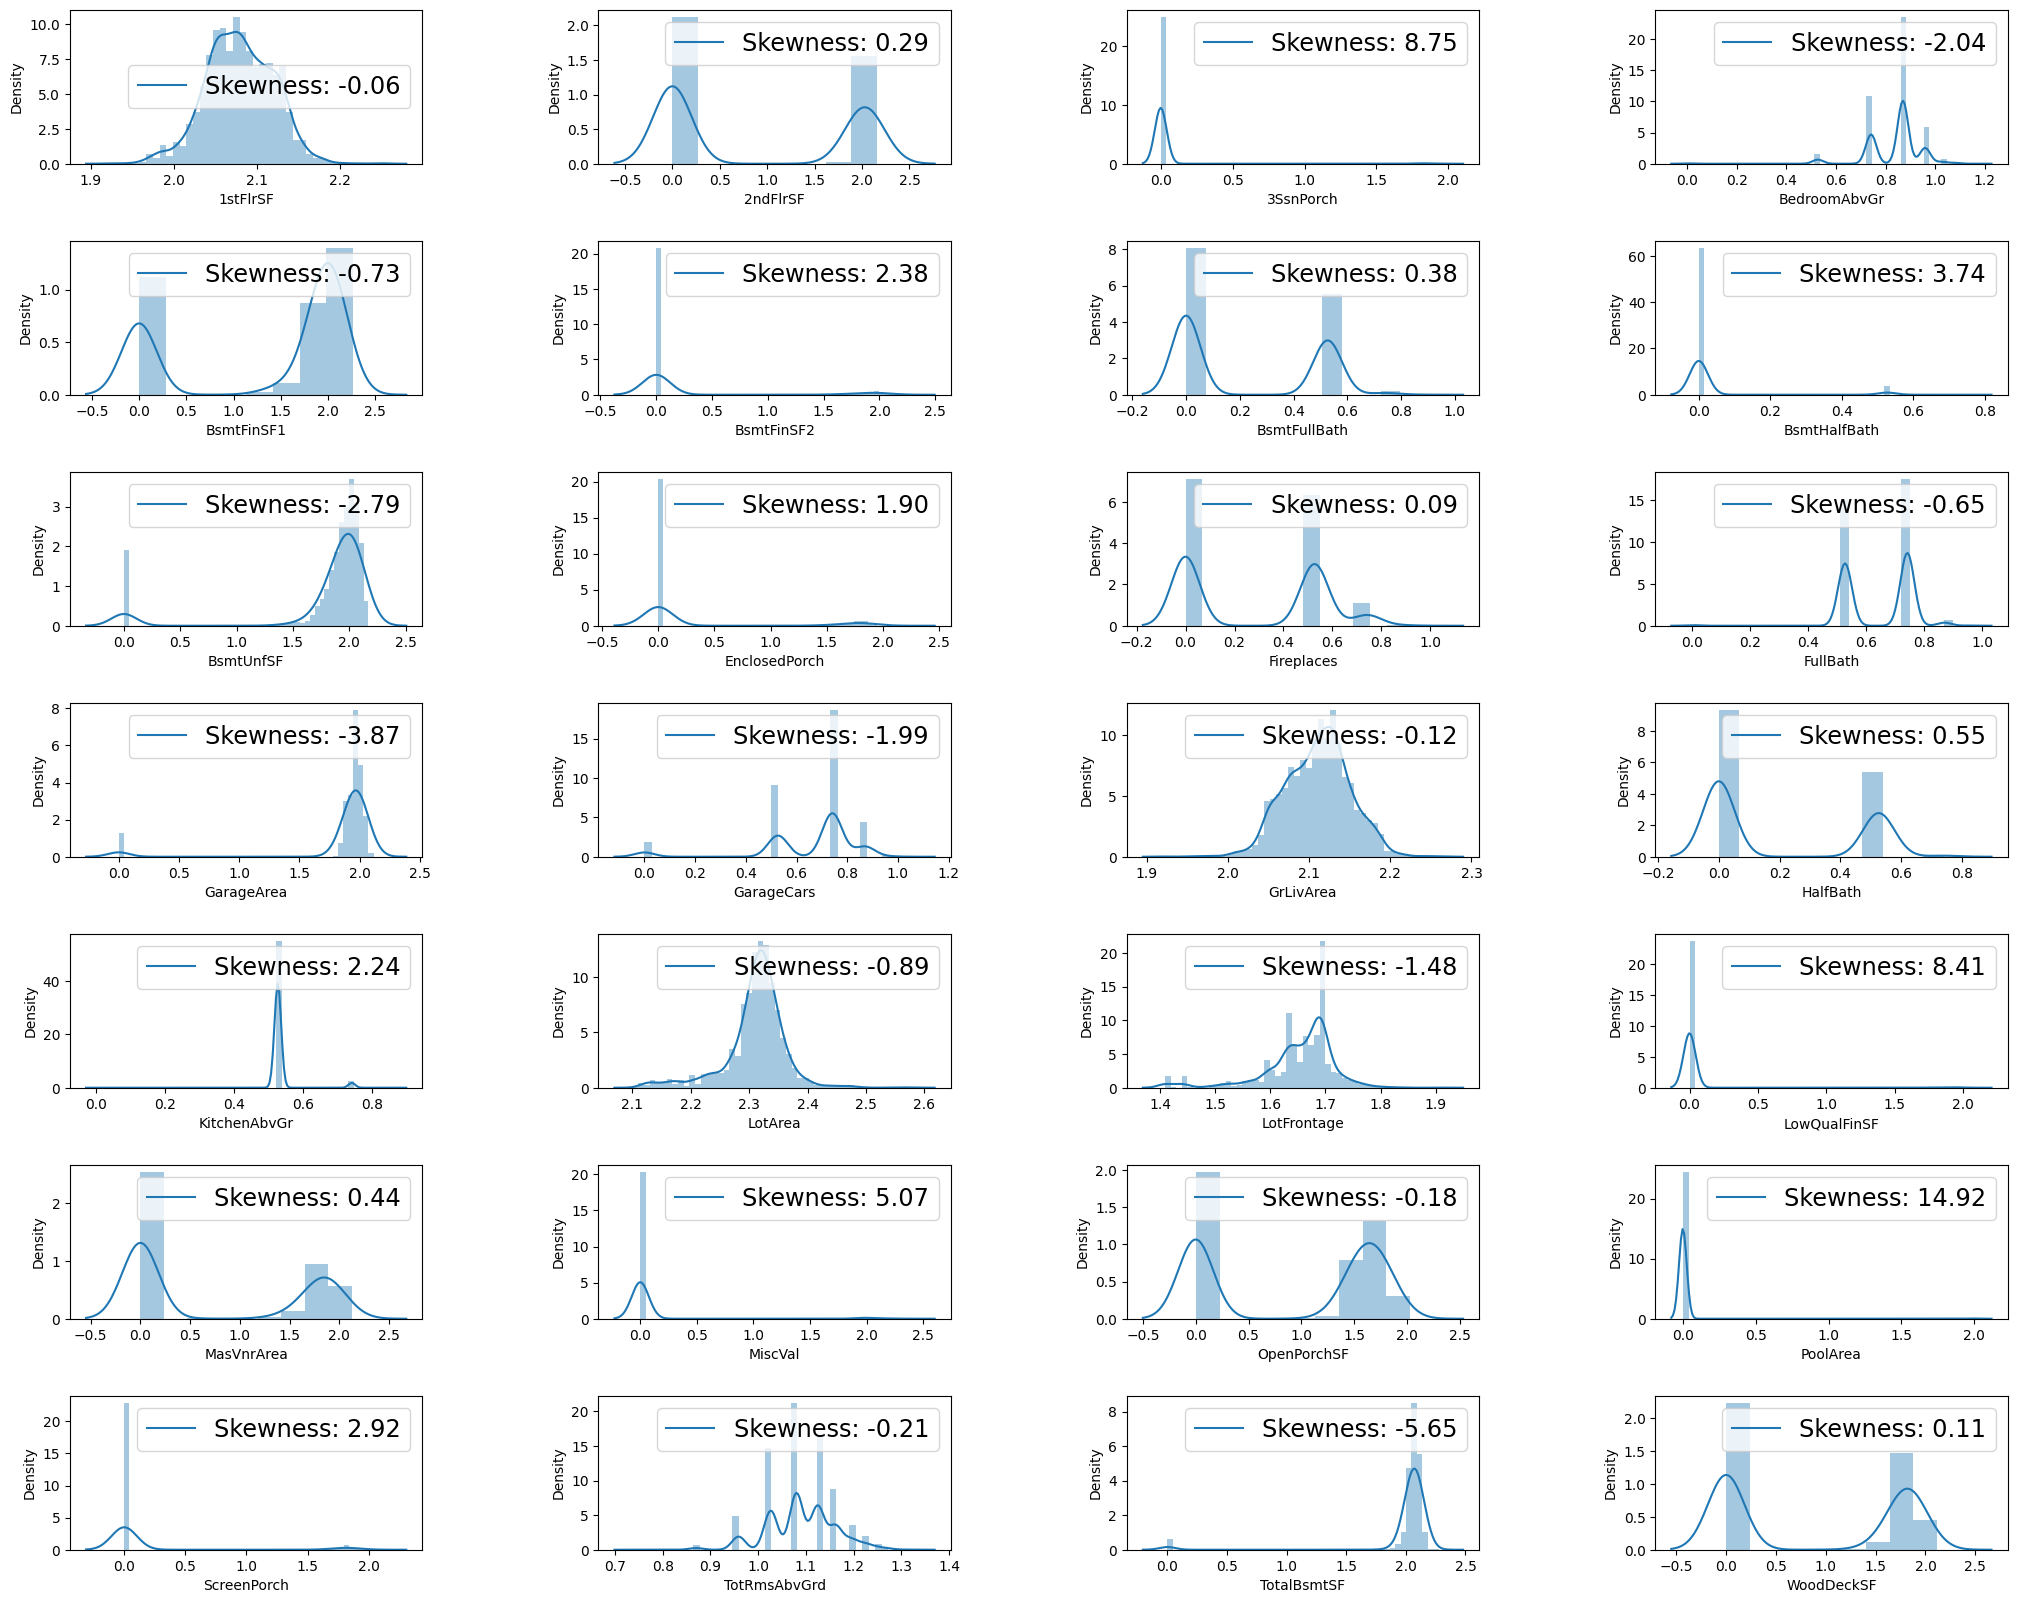

In [82]:
plt.figure(figsize=(25,20))
for i in range(len(skewed_features)):
    if i <= 28:
        plt.subplot(7,4,i+1)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
        ax = sns.distplot(df[skewed_features[i]])
        ax.legend(["Skewness: {:.2f}".format(df[skewed_features[i]].skew())], fontsize = 'xx-large')

In [83]:
SalePrice = np.log(train['SalePrice'] + 1)

In [84]:
obj_feat = list(df.loc[:,df.dtypes == 'object'].columns.values)
len(obj_feat)

28

In [85]:
dummy_drop = []
clean_df = df
for i in obj_feat:
    dummy_drop += [i + '_' + str(df[i].unique()[-1])]

df = pd.get_dummies(df, columns = obj_feat)
df = df.drop(dummy_drop, axis = 1)

In [86]:
df.shape

(2919, 497)

In [87]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(df)
df = scaler.transform(df)

In [88]:
train_len = len(train)

In [89]:
X_train = df[:train_len]
X_test = df[train_len:]
y_train = SalePrice

print(X_train.shape)
print(X_test.shape)
print(len(y_train))

(1460, 497)
(1459, 497)
1460


In [90]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score

def test_model(model, X_train=X_train, y_train=y_train):
    cv = KFold(n_splits = 3, shuffle=True, random_state = 45)
    r2 = make_scorer(r2_score)
    r2_val_score = cross_val_score(model, X_train, y_train, cv=cv, scoring = r2)
    score = [r2_val_score.mean()]
    return score

In [91]:
def test_model(model, X_train, y_train):
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    cv = KFold(n_splits=3, shuffle=True, random_state=45)
    r2 = make_scorer(r2_score)
    r2_val_score = cross_val_score(model, X_train_imputed, y_train, cv=cv, scoring=r2)
    score = [r2_val_score.mean()]
    return score


In [92]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
LR = LinearRegression()
cross_validation = cross_val_score(estimator=LR, X=X_train_imputed, y=y_train, cv=10)
print("Cross validation accuracy of LR model = ", cross_validation)
print("\nCross validation mean accuracy of LR model = ", cross_validation.mean())

Cross validation accuracy of LR model =  [-2.69485578e+16 -4.53983760e+16 -2.23725855e+18 -4.82714060e+15
 -2.00210813e+17 -2.94220014e+18 -4.85369500e+19 -7.39169598e+19
 -1.38603427e+20 -5.19584261e+17]

Cross validation mean accuracy of LR model =  -2.670337649590077e+19


In [93]:
from sklearn import linear_model
rdg = linear_model.Ridge()
test_model(rdg, X_train, y_train)


[0.8652337783535226]

In [94]:
lasso = linear_model.Lasso(alpha=1e-4)
test_model(lasso, X_train, y_train)

[0.8688154298312706]

In [95]:
from sklearn.svm import SVR
svr_reg = SVR(kernel='rbf')
test_model(svr_reg, X_train, y_train)

[0.8703722666312443]

In [96]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=21)
test_model(dt_reg, X_train, y_train)

[0.687314574607178]

In [97]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=1000, random_state=51)
test_model(rf_reg, X_train, y_train)

[0.8563642361569226]

In [98]:
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
br_reg = BaggingRegressor(n_estimators=1000, random_state=51)
gbr_reg = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, loss='ls', random_state=51)

In [99]:
test_model(br_reg, X_train, y_train)

[0.8565136446045015]

In [100]:
from sklearn.ensemble import GradientBoostingRegressor

# Assuming gbr_reg is your GradientBoostingRegressor model
gbr_reg = GradientBoostingRegressor(loss='squared_error', random_state=42)

# Call test_model function with the gbr_reg model
test_model(gbr_reg, X_train, y_train)


[0.8824337580549387]

In [101]:
import xgboost

xgb_reg = xgboost.XGBRegressor(booster='gbtree', random_state=51)
test_model(xgb_reg, X_train, y_train)


[0.8575866898350802]

In [102]:
from sklearn.impute import SimpleImputer

# Instantiate SimpleImputer to replace NaN values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on training data and transform both training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Now train your SVR model on the imputed data
svr_reg.fit(X_train_imputed, y_train)

# Predict on the imputed test data
y_pred = np.exp(svr_reg.predict(X_test_imputed)).round(2)


In [103]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Instantiate HistGradientBoostingRegressor
hist_gb_reg = HistGradientBoostingRegressor()

# Fit the model on training data
hist_gb_reg.fit(X_train, y_train)

# Predict on the test data
y_pred = np.exp(hist_gb_reg.predict(X_test)).round(2)


In [104]:
submit_test1 = pd.concat([test['Id'],pd.DataFrame(y_pred)], axis=1)
submit_test1.columns=['Id', 'SalePrice']

In [105]:
submit_test1

,Id,SalePrice
0,1461,121910.57
1,1462,159816.97
2,1463,184107.26
3,1464,184209.82
4,1465,202442.34
...,...,...
1454,2915,77829.57
1455,2916,84857.48
1456,2917,164211.66
1457,2918,110937.15


In [106]:
submit_test1.to_csv('sample_submission.csv', index=False )

In [107]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR

# Instantiate SVR model
svr_reg = SVR()

# Define the parameter grid for the randomized search
params = {
    'kernel': ['rbf'],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'C': [0.1, 1, 10, 100, 1000],
    'epsilon': [1, 0.2, 0.1, 0.01, 0.001, 0.0001]
}

# Instantiate SimpleImputer to replace NaN values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on training data
X_train_imputed = imputer.fit_transform(X_train)

# Create a new SVR model to use in RandomizedSearchCV
svr_reg_imputed = SVR()

# Create a RandomizedSearchCV instance with the imputed data
rand_search = RandomizedSearchCV(svr_reg_imputed, param_distributions=params, n_jobs=-1, cv=11)
rand_search.fit(X_train_imputed, y_train)

# Print the best score and best parameters
print("Best Score: ", rand_search.best_score_)
print("Best Parameters: ", rand_search.best_params_)


Best Score:  0.8861665228502762
Best Parameters:  {'kernel': 'rbf', 'gamma': 0.01, 'epsilon': 0.001, 'C': 10}


In [108]:
# Assuming you have X_train and y_train defined somewhere in your code

# Define svr_reg
svr_reg = SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.0001,
              kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# Call test_model function with svr_reg, X_train, and y_train
test_model(svr_reg, X_train, y_train)


[0.8939565225304071]

In [109]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
svr_reg.fit(X_train_imputed, y_train)
y_pred = np.exp(svr_reg.predict(X_test_imputed)).round(2)

In [110]:
submit_test3 = pd.concat([test['Id'],pd.DataFrame(y_pred)], axis=1)
submit_test3.columns=['Id', 'SalePrice']

In [111]:
submit_test3.to_csv('sample_submission.csv', index=False)
submit_test3

,Id,SalePrice
0,1461,114131.36
1,1462,161077.69
2,1463,185903.84
3,1464,197643.96
4,1465,188912.47
...,...,...
1454,2915,89929.08
1455,2916,79249.99
1456,2917,176354.73
1457,2918,118343.14


In [112]:
xgb2_reg = xgboost.XGBRegressor(
    n_estimators=899,
    mon_child_weight=2,
    max_depth=4,
    learning_rate=0.05,
    booster='gbtree'
)

test_model(xgb2_reg, X_train, y_train)


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:33:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "mon_child_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:33:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "mon_child_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:33:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "mon_child_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0.879806741027692]

In [113]:
xgb2_reg.fit(X_train,y_train)
y_pred_xgb_rs=xgb2_reg.predict(X_test)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:33:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "mon_child_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [114]:
np.exp(y_pred_xgb_rs).round(2)

array([124183.2 , 161435.27, 184414.08, ..., 156645.34, 116481.57,
       208185.81], dtype=float32)

In [115]:
y_pred_xgb_rs = np.exp(xgb2_reg.predict(X_test)).round(2)
xgb_rs_solution = pd.concat([test['Id'], pd.DataFrame(y_pred_xgb_rs)], axis=1)
xgb_rs_solution.columns=['Id', 'SalePrice']
xgb_rs_solution.to_csv('sample_submission.csv', index=False)

In [116]:
xgb_rs_solution

,Id,SalePrice
0,1461,124183.203125
1,1462,161435.265625
2,1463,184414.078125
3,1464,189911.046875
4,1465,190027.187500
...,...,...
1454,2915,77559.039062
1455,2916,79591.398438
1456,2917,156645.343750
1457,2918,116481.570312


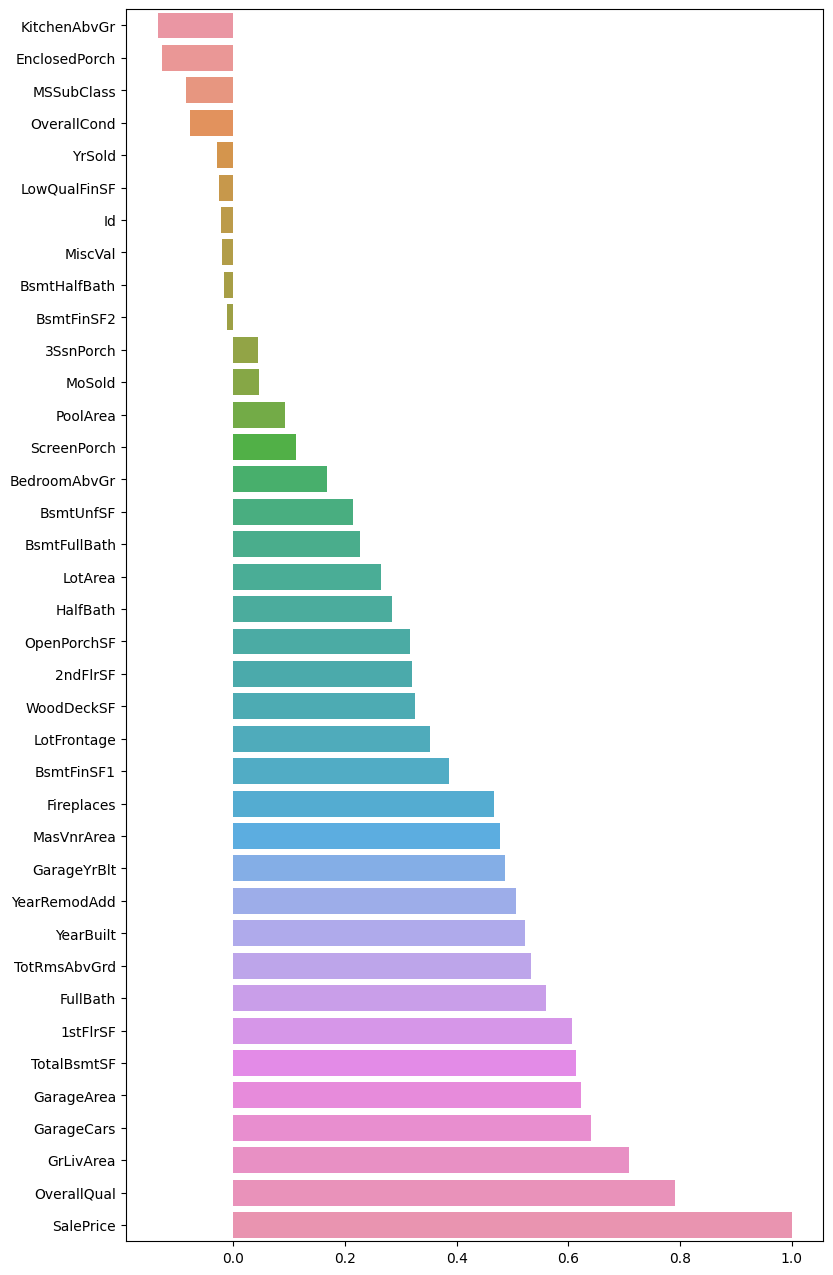

In [117]:
numeric_train = train.select_dtypes(include=['number'])
plt.figure(figsize=(9,16))
corr_feat_series = numeric_train.corrwith(train['SalePrice'])
corr_feat_series = corr_feat_series.sort_values()  # Sort the correlation values
sns.barplot(x=corr_feat_series, y=corr_feat_series.index, orient='h')
plt.show()

In [118]:
df_back1 = df_back

In [119]:
df_back1.to_csv('df_for_feature_engineering.csv', index=False)

In [120]:
list(corr_feat_series.index)

['KitchenAbvGr',
 'EnclosedPorch',
 'MSSubClass',
 'OverallCond',
 'YrSold',
 'LowQualFinSF',
 'Id',
 'MiscVal',
 'BsmtHalfBath',
 'BsmtFinSF2',
 '3SsnPorch',
 'MoSold',
 'PoolArea',
 'ScreenPorch',
 'BedroomAbvGr',
 'BsmtUnfSF',
 'BsmtFullBath',
 'LotArea',
 'HalfBath',
 'OpenPorchSF',
 '2ndFlrSF',
 'WoodDeckSF',
 'LotFrontage',
 'BsmtFinSF1',
 'Fireplaces',
 'MasVnrArea',
 'GarageYrBlt',
 'YearRemodAdd',
 'YearBuilt',
 'TotRmsAbvGrd',
 'FullBath',
 '1stFlrSF',
 'TotalBsmtSF',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'OverallQual',
 'SalePrice']

In [121]:
import pickle
model_house_price_prediction = pickle.load(open('model_house_price_prediction.csv', 'rb'))
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_test_imputed = imputer.fit_transform(X_test)
predicted_values = model_house_price_prediction.predict(X_test_imputed)

FileNotFoundError: [Errno 2] No such file or directory: 'model_house_price_prediction.csv'

In [ ]:
test_model(model_house_price_prediction, X_train, y_train)